In [28]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import random

In [29]:
# define parameters 

# these values are taken from GBD compare for middle aged Chinese men
acmr = 0.0106155
csmr = 0.0012779
gbd_incidence = 0.0015212 # incidence rate of CLINICAL TBL cancer (aka from GBD, per general, not susceptible pop)
gbd_prev = 0.0024086 # CLINICAL TBL cancer prevalence (aka from GBD)

odf = 0.1 #overdiagnosis factor
mst = 3 # mean sojourn time
baseline_screening = 0.1

emr = csmr / gbd_prev
ast = 1/(emr + acmr - csmr) #average survival time
c_prev = (baseline_screening *
             (gbd_prev * 1 / (1 + odf)) + 
         (1 - baseline_screening) *
             gbd_prev)

pc_prev = c_prev * mst / ast
i_prev = (baseline_screening *
             (gbd_prev * odf / (1 + odf)) + 
         (1 - baseline_screening) *
             c_prev * odf)
s_prev = 1 - c_prev - i_prev - pc_prev


i_pc = ((1 - baseline_screening) * gbd_incidence + 
       baseline_screening * gbd_incidence * 1 / (1 + odf)) / s_prev
i_i = ((1 - baseline_screening) * i_pc * odf + 
       baseline_screening * gbd_incidence * odf / (1 + odf)) / s_prev
i_c = 1/mst
i_r = 1/10


In [30]:
i_pc

0.0015172162921413602

In [31]:
i_c

0.3333333333333333

In [32]:
c_prev

0.0023867036363636363

In [33]:
pc_prev

0.003865706433442909

In [34]:
pc_prev / c_prev

1.6196843104209915

In [35]:
mst / ast

1.6196843104209915

In [36]:
# initialize sims

n_simulants = 100_000
data = pd.DataFrame()
data['sim'] = list(range(0,n_simulants))
data['t_0'] = np.random.choice(['s','i','pc','c'], n_simulants, p=[s_prev,i_prev,pc_prev,c_prev])
data.head()

,sim,t_0
0,0,s
1,1,s
2,2,s
3,3,s
4,4,s


In [37]:
"""This function walks through a specified number of 
timesteps that allows transitions through the cause model
and deaths due to clinical lung cancer or other causes.
This is a closed cohort with no births into cohort.
This function assumes a timestep of one year."""

def run_sim(data, n_timesteps):
    for i in list(range(1,n_timesteps+1)):
        
        # define propensities for transitions and mortality separately (reset each timestep)
        np.random.seed(i*7)
        data['i_prop'] = np.random.uniform(0,1,len(data))
        data['d_prop'] = np.random.uniform(0,1,len(data))
        
        # transitions from S state
        data.loc[(data[f't_{i-1}'] == 's') & (data['i_prop'] <= i_pc), f't_{i}'] = 'pc*'
        data.loc[(data[f't_{i-1}'] == 's') & (data['i_prop'] <= i_i + i_pc) & (data['i_prop'] > i_pc), f't_{i}'] = 'i*'
        data.loc[(data[f't_{i-1}'] == 's') & (data['i_prop'] > i_i + i_pc), f't_{i}'] = 's'
        
        # no transitions out of I state
        data.loc[(data[f't_{i-1}'] == 'i*'), f't_{i}'] = 'i'
        data.loc[(data[f't_{i-1}'] == 'i'), f't_{i}'] = 'i'
        
        # transitions out of PC state
        data.loc[(data[f't_{i-1}'] == 'pc*') & (data['i_prop'] <= i_c), f't_{i}'] = 'c*'
        data.loc[(data[f't_{i-1}'] == 'pc') & (data['i_prop'] <= i_c), f't_{i}'] = 'c*'
            # c* indicates INCIDENT clinical cancers
        data.loc[(data[f't_{i-1}'] == 'pc*') & (data['i_prop'] > i_c), f't_{i}'] = 'pc'
        data.loc[(data[f't_{i-1}'] == 'pc') & (data['i_prop'] > i_c), f't_{i}'] = 'pc'
        
        # covert incident clinical cancers to standard clinical cancers (c* --> c)
            # can still transition to R state from here
        data.loc[(data[f't_{i-1}'] == 'c*') & (data['i_prop'] <= i_r), f't_{i}'] = 's'
        data.loc[(data[f't_{i-1}'] == 'c*') & (data['i_prop'] > i_r), f't_{i}'] = 'c'
        # transitions out of c state
        data.loc[(data[f't_{i-1}'] == 'c') & (data['i_prop'] <= i_r), f't_{i}'] = 's'
        data.loc[(data[f't_{i-1}'] == 'c') & (data['i_prop'] > i_r), f't_{i}'] = 'c'
        
        # no transitions out of r state
        data.loc[(data[f't_{i-1}'] == 'r'), f't_{i}'] = 'r'
        
        # no transitions out of death states
        data.loc[(data[f't_{i-1}'] == 'dead_other*'), f't_{i}'] = 'dead_other'
        data.loc[(data[f't_{i-1}'] == 'dead_other'), f't_{i}'] = 'dead_other'
        data.loc[(data[f't_{i-1}'] == 'dead_cancer*'), f't_{i}'] = 'dead_cancer'
        data.loc[(data[f't_{i-1}'] == 'dead_cancer'), f't_{i}'] = 'dead_cancer'
        data.loc[(data[f't_{i-1}'] == 'dead_indolent*'), f't_{i}'] = 'dead_indolent'
        data.loc[(data[f't_{i-1}'] == 'dead_indolent'), f't_{i}'] = 'dead_indolent'
        
        
        # determine who dies this timestep
        # this will supercede previous state
        data.loc[(data['d_prop'] <= acmr - csmr) & (data[f't_{i-1}'].isin(['s','pc','pc*','r'])), f't_{i}'] = 'dead_other*'
        data.loc[(data['d_prop'] <= acmr - csmr) & (data[f't_{i-1}'].isin(['c*','c'])), f't_{i}'] = 'dead_other*'
        data.loc[(data['d_prop'] > acmr - csmr) & (data['d_prop'] <= acmr - csmr + emr) & (data[f't_{i-1}'].isin(['c*','c'])), f't_{i}'] = 'dead_cancer*'
           # indolent deaths
        data.loc[(data['d_prop'] < acmr - csmr + emr) & (data[f't_{i-1}'].isin(['i','i*'])), f't_{i}'] = 'dead_indolent*'

        # initialize new simulants (1,000 per timestep)
        new_sims = pd.DataFrame()
        new_sims['sim'] = list(range(0,1_070))
        new_sims[f't_{i}'] = 's'#np.random.choice(['s','i','pc','c'], 1_000, p=[s_prev,i_prev,pc_prev,c_prev])
        data = data.append(new_sims, ignore_index=True)
    
    data = data.drop(columns=['i_prop','d_prop']) 
    return data

In [38]:
test = run_sim(data, 20)
test.head()

/ihme/code/central_comp/miniconda3_10_30_2019/envs/gbd_env/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,sim,t_0,t_1,t_10,t_11,t_12,t_13,t_14,t_15,t_16,...,t_19,t_2,t_20,t_3,t_4,t_5,t_6,t_7,t_8,t_9
0,0,s,s,s,s,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,1,s,s,dead_other,dead_other,dead_other,dead_other,dead_other,dead_other,dead_other,...,dead_other,s,dead_other,dead_other*,dead_other,dead_other,dead_other,dead_other,dead_other,dead_other
2,2,s,s,s,s,s,s,s,s,s,...,s,s,pc*,s,s,s,s,s,s,s
3,3,s,s,s,s,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
4,4,s,s,s,s,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s


Text(0.5, 1.0, 'Pre-Clinical Incidence Rate per 100,000 PY in General Pop')

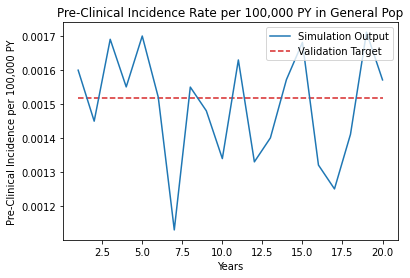

In [39]:
n_preclinical = pd.DataFrame()
for i in list(range(1,20+1)):
    n_preclinical[f't_{i}'] = [len(test.loc[test[f't_{i}'] == 'pc*'])/ len(test.loc[test[f't_{i-1}'].isin(['s','i*','i','pc*','pc','c*','c','r'])])]

plt.plot(list(range(1,20+1)),n_preclinical.transpose()[0])
plt.hlines(i_pc,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('Pre-Clinical Incidence per 100,000 PY')
plt.title('Pre-Clinical Incidence Rate per 100,000 PY in General Pop')

Text(0.5, 1.0, 'Clinical Incidence Rate per 100,000 PY in General Pop')

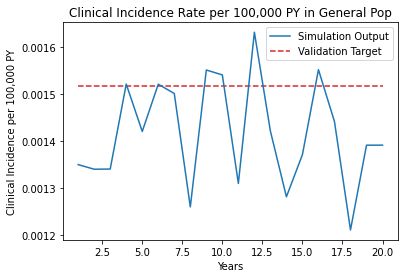

In [40]:
n_clinical = pd.DataFrame()
for i in list(range(1,20+1)):
    n_clinical[f't_{i}'] = [len(test.loc[test[f't_{i}'] == 'c*']) / len(test.loc[test[f't_{i-1}'].isin(['s','i*','i','pc*','pc','c*','c','r'])])]

plt.plot(list(range(1,20+1)),n_clinical.transpose()[0])
plt.hlines(i_pc,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('Clinical Incidence per 100,000 PY')
plt.title('Clinical Incidence Rate per 100,000 PY in General Pop')

Text(0.5, 1.0, 'Clinical Incidence Rate per 100,000 PY in Preclinical Pop')

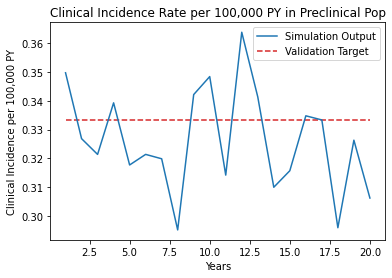

In [41]:
n_clinical = pd.DataFrame()
for i in list(range(1,20+1)):
    n_clinical[f't_{i}'] = [len(test.loc[test[f't_{i}'] == 'c*']) / len(test.loc[test[f't_{i-1}'].isin(['pc*','pc'])])]

plt.plot(list(range(1,20+1)),n_clinical.transpose()[0])
plt.hlines(i_c,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('Clinical Incidence per 100,000 PY')
plt.title('Clinical Incidence Rate per 100,000 PY in Preclinical Pop')

Text(0.5, 1.0, 'Detected Rate per 100,000 PY in General Pop')

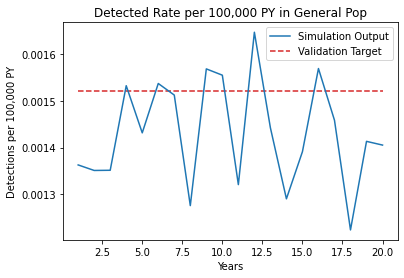

In [42]:
n_detects = pd.DataFrame()
for i in list(range(1,20+1)):
    n_detects[f't_{i}'] = [(len(test.loc[test[f't_{i}'] == 'c*']) + len(test.loc[test[f't_{i}'] == 'i*']) * baseline_screening) / len(test.loc[test[f't_{i-1}'].isin(['s','i*','i','pc*','pc','c*','c','r'])])]

plt.plot(list(range(1,20+1)),n_detects.transpose()[0])
plt.hlines(gbd_incidence,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('Detections per 100,000 PY')
plt.title('Detected Rate per 100,000 PY in General Pop')

Text(0.5, 1.0, 'Detected Rate per 100,000 PY in General Pop')

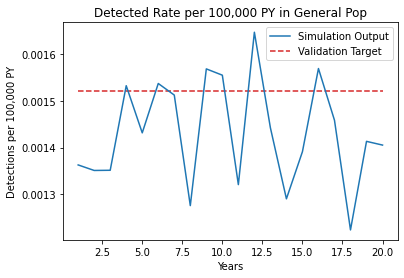

In [43]:
n_detects = pd.DataFrame()
for i in list(range(1,20+1)):
    n_detects[f't_{i}'] = [(len(test.loc[test[f't_{i}'] == 'c*']) + len(test.loc[test[f't_{i}'] == 'i*']) * baseline_screening) / len(test.loc[test[f't_{i-1}'].isin(['s','i*','i','pc*','pc','c*','c','r'])])]

plt.plot(list(range(1,20+1)),n_detects.transpose()[0])
plt.hlines(gbd_incidence,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('Detections per 100,000 PY')
plt.title('Detected Rate per 100,000 PY in General Pop')

Text(0.5, 1.0, 'Cause-Specific Mortality Rate')

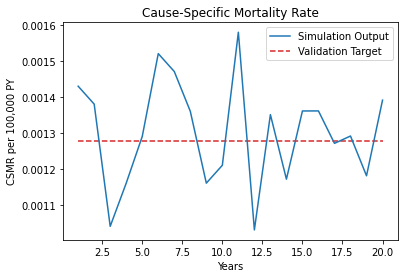

In [44]:
n_deaths = pd.DataFrame()
for i in list(range(1,20+1)):
    n_deaths[f't_{i}'] = [len(test.loc[test[f't_{i}'] == 'dead_cancer*']) / len(test.loc[test[f't_{i-1}'].isin(['s','i*','i','pc*','pc','c*','c','r'])])]

plt.plot(list(range(1,20+1)),n_deaths.transpose()[0])
plt.hlines(csmr,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('CSMR per 100,000 PY')
plt.title('Cause-Specific Mortality Rate')

Text(0.5, 1.0, 'All-Cause Mortality Rate')

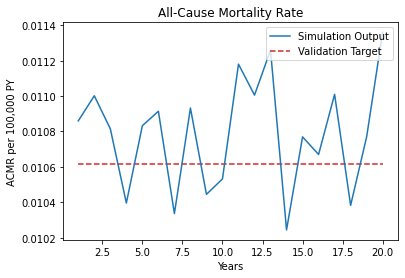

In [45]:
n_deaths = pd.DataFrame()
for i in list(range(1,20+1)):
    n_deaths[f't_{i}'] = [len(test.loc[test[f't_{i}'].isin(['dead_cancer*','dead_other*','dead_indolent*'])]) / len(test.loc[test[f't_{i-1}'].isin(['s','i*','i','pc*','pc','c*','c','r'])])]

plt.plot(list(range(1,20+1)),n_deaths.transpose()[0])
plt.hlines(acmr,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('ACMR per 100,000 PY')
plt.title('All-Cause Mortality Rate')

Text(0.5, 1.0, 'Excess Mortality Rate')

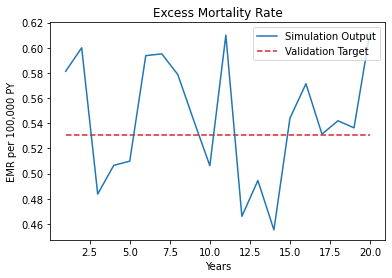

In [46]:
n_deaths = pd.DataFrame()
for i in list(range(1,20+1)):
    n_deaths[f't_{i}'] = [len(test.loc[test[f't_{i}']=='dead_cancer*']) / len(test.loc[test[f't_{i-1}'].isin(['c*','c'])])]

plt.plot(list(range(1,20+1)),n_deaths.transpose()[0])
plt.hlines(emr,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('EMR per 100,000 PY')
plt.title('Excess Mortality Rate')
# looks decent

Text(0.5, 1.0, 'Preclinical Prevalence')

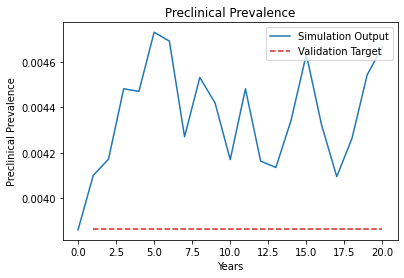

In [47]:
pc_prev_plot = pd.DataFrame()
for i in list(range(0,20+1)):
    pc_prev_plot[f't_{i}'] = [len(test.loc[test[f't_{i}'].isin(['pc*','pc'])]) / len(test.loc[test[f't_{i}'].isin(['s','i*','i','pc*','pc','c*','c','r'])])]

plt.plot(list(range(0,20+1)),pc_prev_plot.transpose()[0])
plt.hlines(pc_prev,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('Preclinical Prevalence')
plt.title('Preclinical Prevalence')
# too high!

Text(0.5, 1.0, 'Clinical Prevalence')

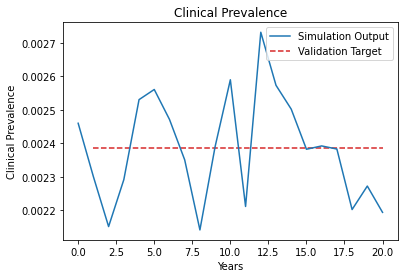

In [48]:
c_prev_plot = pd.DataFrame()
for i in list(range(0,20+1)):
    c_prev_plot[f't_{i}'] = [len(test.loc[test[f't_{i}'].isin(['c*','c'])]) / len(test.loc[test[f't_{i}'].isin(['s','i*','i','pc*','pc','c*','c','r'])])]

plt.plot(list(range(0,20+1)),c_prev_plot.transpose()[0])
plt.hlines(c_prev,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('Clinical Prevalence')
plt.title('Clinical Prevalence')
# too high

Text(0.5, 1.0, 'Detected Prevalence')

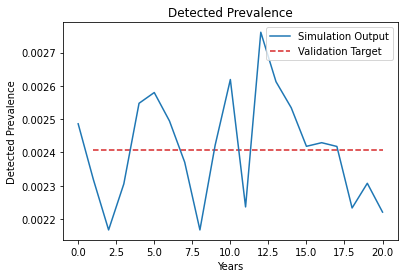

In [49]:
detected_prev_plot = pd.DataFrame()
for i in list(range(0,20+1)):
    detected_prev_plot[f't_{i}'] = [(len(test.loc[test[f't_{i}'].isin(['c*','c'])]) + len(test.loc[test[f't_{i}'].isin(['i*','i'])]) * baseline_screening) / len(test.loc[test[f't_{i}'].isin(['s','i*','i','pc*','pc','c*','c','r'])])]

plt.plot(list(range(0,20+1)),detected_prev_plot.transpose()[0])
plt.hlines(gbd_prev,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('Detected Prevalence')
plt.title('Detected Prevalence')
# too high

Text(0.5, 1.0, 'Susceptible Prevalence')

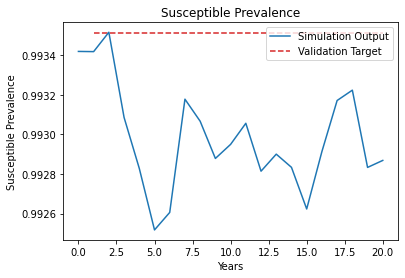

In [50]:
s_prev_plot = pd.DataFrame()
for i in list(range(0,20+1)):
    s_prev_plot[f't_{i}'] = [len(test.loc[test[f't_{i}'] == 's']) / len(test.loc[test[f't_{i}'].isin(['s','i*','i','pc*','pc','c*','c','r'])])]

plt.plot(list(range(0,20+1)),s_prev_plot.transpose()[0])
plt.hlines(s_prev,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('Susceptible Prevalence')
plt.title('Susceptible Prevalence')
# too high

Text(0.5, 1.0, 'Recovered Prevalence')

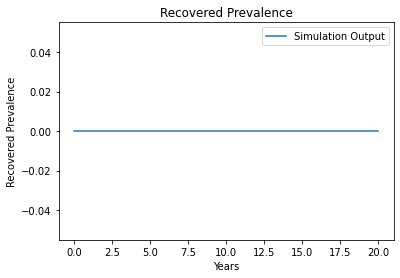

In [51]:
r_prev_plot = pd.DataFrame()
for i in list(range(0,20+1)):
    r_prev_plot[f't_{i}'] = [len(test.loc[test[f't_{i}'] == 'r']) / len(test.loc[test[f't_{i}'].isin(['s','i*','i','pc*','pc','c*','c','r'])])]

plt.plot(list(range(0,20+1)),r_prev_plot.transpose()[0])
#plt.hlines(s_prev,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('Recovered Prevalence')
plt.title('Recovered Prevalence')
# too high

Text(0.5, 1.0, 'Population Size')

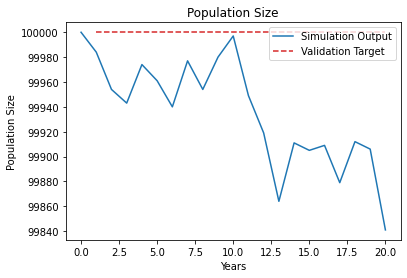

In [52]:
pop_size_plot = pd.DataFrame()
for i in list(range(0,20+1)):
    pop_size_plot[f't_{i}'] = [len(test.loc[test[f't_{i}'].isin(['s','i*','i','pc*','pc','c*','c','r'])])]

plt.plot(list(range(0,20+1)),pop_size_plot.transpose()[0])
plt.hlines(100_000,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('Population Size')
plt.title('Population Size')
# too high

Text(0.5, 1.0, 'Indolent Prevalence')

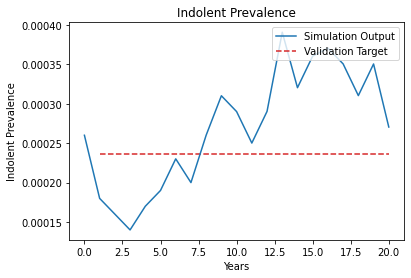

In [53]:
i_prev_plot = pd.DataFrame()
for i in list(range(0,20+1)):
    i_prev_plot[f't_{i}'] = [len(test.loc[test[f't_{i}'].isin(['i*','i'])]) / len(test.loc[test[f't_{i}'].isin(['s','i*','i','pc*','pc','c*','c','r'])])]

plt.plot(list(range(0,20+1)),i_prev_plot.transpose()[0])
plt.hlines(i_prev,1,20,colors='tab:red',linestyles='dashed', label='Validation target')
plt.legend(['Simulation Output','Validation Target'], loc='upper right')
plt.xlabel('Years')
plt.ylabel('Indolent Prevalence')
plt.title('Indolent Prevalence')

# issue